## Weekly Monitoring of Field Imaging Activities

Tools for measuring 2020 field imaging progress against specific data collection goals.

An extension of the tools developed in the xdcm dashboard.


In [1]:
# Import libraries and query Aletheia
# May take several minutes to run depending on query parameters

import time
import numpy as np
import pandas as pd
from datetime import datetime as dt
from brtdevkit.core.db import DBConnector, DatetimeFilter
from matplotlib import pyplot as plt, rcParams
import seaborn as sns
sns.set_style('whitegrid')

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. Written by Andrei P.
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

# Set filters for query
#filters = {"artifacts.kind": "nrg", 
           #"crop_name": {"$in": ['CORN', 'COTTON', 'SOYBEANS']}, 
           #"robot_name": {"$in": ["DCM-MANATEE","DCM-OTTER", "DCM-DOLPHIN", "DCM-WALRUS", "DCM-PORPOISE", "DCM-SEAL"]} }
dcms = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
# , "experiment_id":"representative weed press",
# filter images by robot_name, image type, crop, etc
filters = {"artifacts.kind": "nrg","crop_name": {"$in": ['SOYBEANS', 'CORN', 'COTTON']}, 'robot_name':{'$in':dcms}}
        
# Set start date
start = dt(2020, 3,1)

full_df, elapsed_time = get_shasta_data(filters=filters, start=start)
full_df['date_collected'] = pd.to_datetime(full_df['collected_on'].dt.date)
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

Queried 521654 images in 433.25 s.


In [2]:
qdf=full_df.copy()
qdf = qdf[(qdf['has_human_annotation']==True)&(qdf['crop_name']=='SOYBEANS')]
qdf['lat_lon'] = qdf.apply(lambda x: (x['latitude'], x['longitude']), axis=1)

#print(qdf[(qdf['latitude']==35.671077728271484)&(qdf['longitude']==-90.19627380371094)]['robot_name'])
identical = qdf['lat_lon'].value_counts().sort_values()[-36:]
print(np.sum(identical))
identical

207


(32.576778411865234, -91.43036651611328)     4
(35.50861358642578, -91.23123168945312)      4
(35.70009994506836, -90.24120330810547)      4
(35.50834274291992, -91.23170471191406)      4
(35.507850646972656, -91.23165893554688)     4
(32.56386184692383, -91.41969299316406)      4
(35.40495681762695, -91.2560043334961)       4
(35.40462112426758, -91.25731658935547)      4
(35.499107360839844, -91.23002624511719)     4
(35.507930755615234, -91.23149108886719)     4
(35.700103759765625, -90.241455078125)       4
(35.69998550415039, -90.24150085449219)      4
(32.42731475830078, -91.86714172363281)      4
(35.40458679199219, -91.25728607177734)      5
(35.507930755615234, -91.23140716552734)     5
(35.507930755615234, -91.23143005371094)     5
(35.490394592285156, -91.22270965576172)     5
(35.507930755615234, -91.2314453125)         5
(35.507930755615234, -91.2313003540039)      5
(35.49884796142578, -91.23002624511719)      5
(32.47257995605469, -91.87535858154297)      5
(35.404613494

In [37]:
#identical = qdf['lat_lon'].value_counts().sort_values()[-100:]
m =[]
for i, j in identical.index:
    m.append(qdf[(qdf['latitude']==i)&(qdf['longitude']==j)].robot_name.unique())
machines = pd.Series(m)
machines.value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[SHASTA-FB-BRADLEY]    22
[BLACKBIRD]            10
[SHASTA-FB-PALADIN]     2
[DCM-MANATEE]           1
[DCM-DOLPHIN]           1
dtype: int64

In [3]:
# Create dataframe of distance covered and number of images collected per field
# Vectorizing these calculations would get rid of these for loops and make this cell run a bit faster

from geopy import distance

qdf = full_df.copy()

# Determine Distance
ds = []
ns = []
cms= []
fields = []
dcms = qdf.groupby(['grower','robot_name','operating_field_name']).count().reset_index()
dc = dcms['robot_name'].unique()

for d in dc:
    ddf = qdf[qdf['robot_name']==d]
    for o in ddf['operating_field_name'].unique():
        op = ddf[ddf['operating_field_name']== o]
        features = [d.get('coordinates') for d in op.gnss]
        dst = 0
        for n in range(1,len(op)-1):
            first_lat_long = [features[n-1][1], features[n-1][0]]
            last_lat_long = [features[n][1], features[n][0]]
            dist_travelled = distance.distance(first_lat_long, last_lat_long).meters
            if (dist_travelled < 2) and (dist_travelled > 0):
                dst+=(dist_travelled)
        ds.append(dst)
        fields.append(o)
        cms.append(d)
        ns.append(len(op))

dcm_distances = pd.DataFrame({'dcm_name':cms, 'operating_field_name':fields, 'n_images_collected':ns, 'distance_covered':ds})

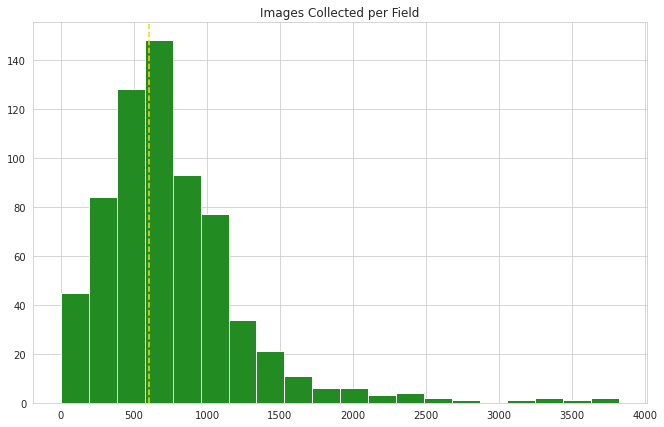

We have collected 754.4 images per field on average.
Of the 669 fields collected to date in 2020, 57.55% of them have at least 600 images.


In [4]:
# How many images are we collecting per field?

plt.figure(figsize=(11,7))
plt.hist(dcm_distances['n_images_collected'], bins=20, color='forestgreen')
plt.title('Images Collected per Field')
plt.axvline(600, color='gold', linestyle='--')
plt.show()

under_spec = len(dcm_distances[dcm_distances['n_images_collected']>=600])

print(f'We have collected {np.mean(dcm_distances.n_images_collected):.1f} images per field on average.')
print(f'Of the {len(dcm_distances)} fields collected to date in 2020, {((under_spec/len(dcm_distances))*100):.2f}% of them have at least 600 images.')

In [5]:
# How does the number of images collected per field vary by DCM?

mean_distances = dcm_distances.groupby(['dcm_name']).mean()
mean_distances['images/meter'] = mean_distances['n_images_collected']/mean_distances['distance_covered']
mean_distances = mean_distances[mean_distances['images/meter']<4]

mean_distances

,n_images_collected,distance_covered,images/meter
dcm_name,,,
DCM-DOLPHIN,478.189944,383.983899,1.245339
DCM-MANATEE,773.252427,465.724338,1.660322
DCM-OTTER,1015.744048,888.600423,1.143083
DCM-PORPOISE,499.000000,367.693450,1.357109
DCM-SEAL,627.776316,515.999098,1.216623
DCM-WALRUS,1049.923077,544.808106,1.927143


There are 2155 total field/camera_height combinations, with an average of 227.33 images per field/camera height combination
There are 1105 field/camera height combinations that meet the 200 image threshold, or 51.28% of all combinations


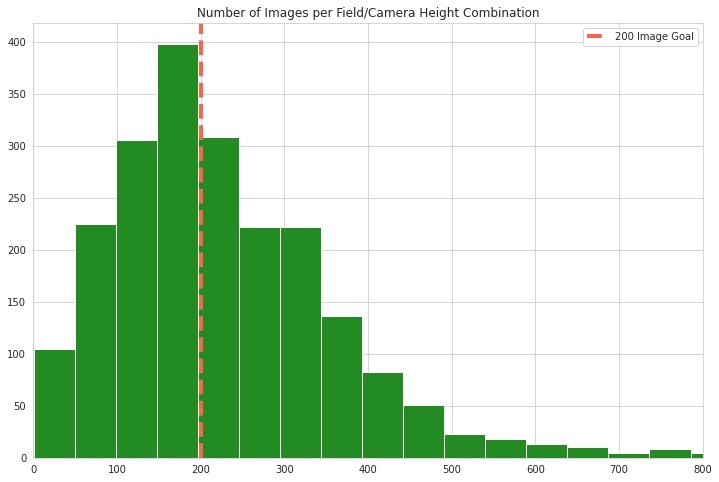

In [6]:
# How many images are we collecting at each camera height/field combination

qdf = full_df.copy()

# Set to be past a certain date (i.e within the past week)
#qdf=qdf[qdf['date_collected'] > '2020-06-14']

fdf = qdf[qdf['grower'] != 'greenway coop'] # Filter Out Bradley Field Data From Arkansas 
qdf = qdf.groupby(['grower', 'farm', 'operating_field_name', 'camera_height']).count()
compliant_fields = len(qdf[qdf['_id'] >= 200])
print(f'There are {len(qdf)} total field/camera_height combinations, with an average of {(len(fdf)/len(qdf)):.2f} images per field/camera height combination')
print(f'There are {compliant_fields} field/camera height combinations that meet the 200 image threshold, or {(compliant_fields/len(qdf))*100:.2f}% of all combinations')

plt.figure(figsize=(12,8))
plt.axvline(200, linestyle= '--', color='tomato', linewidth=4)
plt.title('Number of Images per Field/Camera Height Combination')
plt.legend(['200 Image Goal'])
plt.hist(qdf['_id'], bins =50, color='forestgreen')
plt.xlim(0,800)
plt.show()

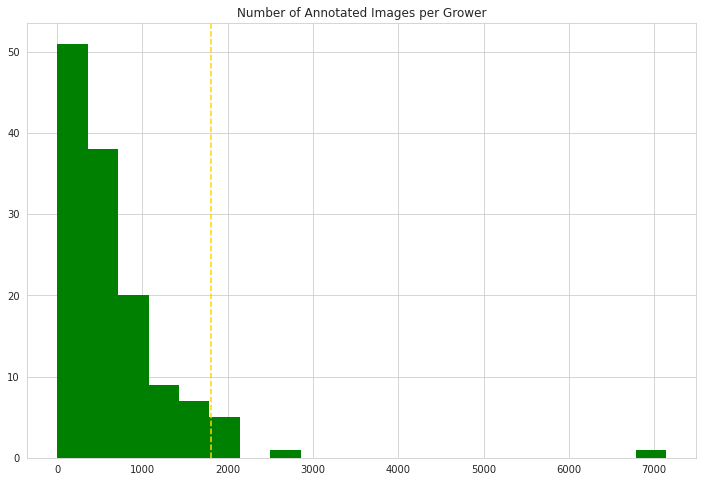

Of the 132 growers we have annotated images for, only 6 or 4.5% have more than 1800 annotated images.


grower          crop_name
greenway coop   SOYBEANS     7138
hoelscher bros  CORN         1828
james connelly  COTTON       2821
shewmaker       COTTON       2009
skiles          CORN         2032
wilmot          SOYBEANS     1987
Name: _id, dtype: int64

In [7]:
# Are we annotating more than 1800 images for any grower/crop combination?

qdf = full_df.copy()

# Select only annotated image
an =qdf[qdf['has_human_annotation'] == True]

an_growers = an.groupby(['grower','crop_name']).count()

plt.figure(figsize=(12,8))
plt.title('Number of Annotated Images per Grower')
plt.hist(an_growers['_id'], bins=20, color='green', linewidth=0)
plt.axvline(1800, linestyle='--', color='gold')
plt.show()

overg = an_growers[an_growers['_id']>1800]

print(f'Of the {len(an_growers)} growers we have annotated images for, only {len(overg)} or {(len(overg)/len(an_growers))*100:.1f}% have more than 1800 annotated images.')
overg['_id']

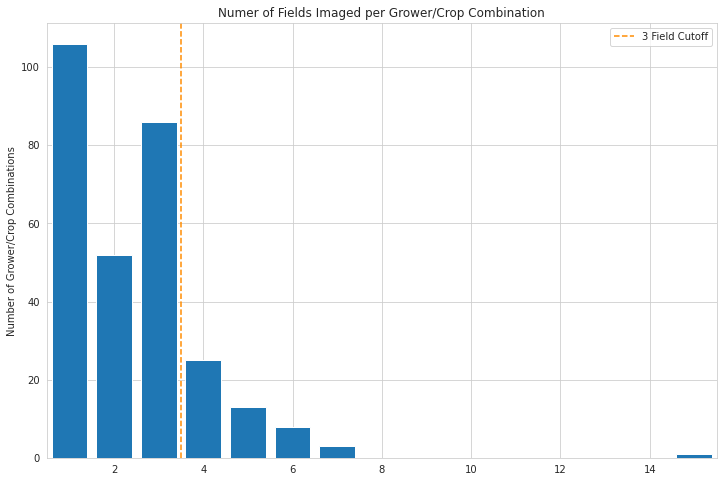

Out of 294 grower/crop combinations, there were 50 or 17.0% with more than 3 fields listed.


grower                crop_name
Allen Below           SOYBEANS      4
Andy ISG              SOYBEANS      4
Craig Warner          SOYBEANS      5
Dave Lunstra          SOYBEANS      4
Dirk Haarberg         SOYBEANS      4
Eddie Smith           COTTON        5
Eric Ristad           SOYBEANS      4
Jared Hagert          SOYBEANS      6
Jared Osborne         SOYBEANS      4
Jason Evans           SOYBEANS      4
Jeff Erbes            SOYBEANS      4
Josh Omlid            SOYBEANS      6
Kyle Patten           SOYBEANS      4
Loren Sprouse         SOYBEANS      6
Micael Mcelwain       SOYBEANS      4
Neil Lee              COTTON        5
Nikki Meyer           SOYBEANS      6
Robert Shoemaker      SOYBEANS      5
Rodney Dawson         COTTON        4
Ron Glissendorf       SOYBEANS      6
Steve Johnson         SOYBEANS      6
Tim Woods             COTTON        5
Todd Ochsner          SOYBEANS      6
Tony Peirick          SOYBEANS      4
Tyler Deen            COTTON        6
arva intelligence 

In [30]:
# Are we collecting too many fields per grower per crop (>3 fields)? (Demo fields excluded from this)

qdf = full_df.copy()
fcg_combos = qdf.groupby(['grower', 'operating_field_name','crop_name']).count().reset_index()
fcg_combos['count'] = 1
counts = fcg_combos.groupby(['grower', 'crop_name']).count().groupby(['count']).count()['_id']

plt.figure(figsize=(12,8))
plt.bar(x= counts.index, height = counts)
plt.title('Numer of Fields Imaged per Grower/Crop Combination')
plt.axvline(3.5, color='darkorange', linestyle='--')
plt.xlim(0.5,15.5)
plt.ylabel('Number of Grower/Crop Combinations')
plt.legend(['3 Field Cutoff'])
plt.savefig('grower_fields.png')
plt.show()

over = avgs[avgs>3]
print(f'Out of {len(avgs)} grower/crop combinations, there were {len(over)} or {(len(over)/len(avgs))*100:.1f}% with more than 3 fields listed.')
over

In [ ]:
# Are we collecting too many fields per grower per crop (>3 fields)? (Demo fields excluded from this)



In [9]:
# Should we aim to collect more data on damaged or unhealthy crops? 
qdf =full_df.copy()
from sklearn.preprocessing import MultiLabelBinarizer

# One-hot encoding each unique weed
s = qdf['crop_damage']
mlb = MultiLabelBinarizer()
w= pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=qdf.index)
l = qdf[['grower', 'farm','operating_field_name','crop_name']]
damage_df = pd.merge(w, l, left_index=True, right_index=True)

damaged_fields = damage_df.groupby(['crop_name','operating_field_name']).sum()
damaged_fields = damaged_fields[damaged_fields['NONE']==0].reset_index()

# Count Fields with Crop Damage
damages = ['CUPPING', 'OTHER', 'SPOTTING', 'TATTERING', 'WILTING', 'YELLOWING']
dmg = pd.Series(damages, name='Damage Type')
master=pd.Series(damages, name = 'crop_damage')
crops = damaged_fields.crop_name.unique()

for c in crops:
    dfs = damaged_fields[damaged_fields['crop_name']==c]
    ds = []
    for d in damages:
        ds.append(len(dfs[dfs[d]>0]))
    ds = pd.Series(ds, name=(c[0] + c[1:].lower()+' Fields'))
    dmg = pd.concat([dmg, ds], axis=1)
    
dmg

,Damage Type,Corn Fields,Cotton Fields,Soybeans Fields
0,CUPPING,2,1,0
1,OTHER,0,2,16
2,SPOTTING,0,1,2
3,TATTERING,2,1,3
4,WILTING,1,0,0
5,YELLOWING,6,3,5


In [10]:
# Are we collecting enough fields with different crop_health conditions?
qdf = full_df.copy()

crops = ['CORN','SOYBEANS','COTTON']
field_health = qdf.groupby(['crop_name','operating_field_name','crop_health']).count().reset_index()
chs = field_health['crop_health'].unique()
crop_health = pd.Series(chs, name='Crop Health')

for c in crops:
    he = field_health[field_health['crop_name']==c]
    hl = []
    for h in chs:
        nh = he[he['crop_health'] == h]
        hl.append(len(nh))
    hlt = pd.Series(hl, name=(c[0] + c[1:].lower()+' Fields'))
    crop_health = pd.concat([crop_health, hlt], axis=1)

crop_health

,Crop Health,Corn Fields,Soybeans Fields,Cotton Fields
0,HEALTHY,91,394,171
1,STRESSED,13,11,4
2,REPLANTED_HEALTHY,1,2,0
3,NOT_STRESSED,0,1,0
